<h1>Proyecto 3 - probabilidad y estadistica </h1>

<h2>- Miguel Angel Nava Perez <br>
- Ana Luisa Parra Valencia </h2>

<h1> REGRESIÓN </h1>
<h2> Análisis exploratorio del proyecto anterior </h2>


In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as scp
from scipy import stats
from tabulate import tabulate


import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, validation_curve, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
#cargar datos y analizar correlaciones 

In [108]:
df = (pd.read_csv("archivos/FLIR_groups1and2.csv", sep=";" , header=2))[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4', 
        'Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4',
        'T_Max1', 'T_Max2', 'T_Max3', 'T_Max4',
        'T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4',
        'aveOralM', 'Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Cosmetics','Distance']].copy() #cargamos el dataframe


#creamos la nueva columna con el valor promediado de Max1R13 y eliminamos las demás
df['Max1R13'] = df[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4'],inplace=True) 

#creamos la nueva columna con el valor promediado de Max1L13 y eliminamos las demás
df['Max1L13'] = df[['Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['Max1L13_1', 'Max1L13_2', 'Max1L13_3', 'Max1L13_4'],inplace=True)

#creamos la nueva columna con el valor promediado de T_Max y eliminamos las demás
df['T_Max'] = df[['T_Max1', 'T_Max2', 'T_Max3', 'T_Max4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['T_Max1', 'T_Max2', 'T_Max3', 'T_Max4'],inplace=True)

#creamos la nueva columna con el valor promediado de TF_HCC y eliminamos las demás
df['TF_HCC'] = df[['T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4']].mean(axis=1, skipna=True).astype(float)
df.drop(columns=['T_FHCC1', 'T_FHCC2', 'T_FHCC3', 'T_FHCC4'],inplace=True)

#procedemos a imputar los valores nulos de cosmetics con la mediana

df["Cosmetics"] = df["Cosmetics"].fillna("No")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   aveOralM   1020 non-null   float64
 1   Gender     1020 non-null   object 
 2   Age        1020 non-null   object 
 3   Ethnicity  1020 non-null   object 
 4   T_atm      1020 non-null   float64
 5   Humidity   1020 non-null   float64
 6   Cosmetics  1020 non-null   object 
 7   Distance   1018 non-null   float64
 8   Max1R13    1020 non-null   float64
 9   Max1L13    1020 non-null   float64
 10  T_Max      1020 non-null   float64
 11  TF_HCC     1020 non-null   float64
dtypes: float64(8), object(4)
memory usage: 95.8+ KB


In [109]:
# Columnas numéricas
df_num = df[['Max1R13','Max1L13','T_Max','TF_HCC',"aveOralM"]]

metricas_num = pd.DataFrame({ 
    'Media': df_num.mean(), 
    'Mediana': df_num.median(),
    'Moda': df_num.mode().iloc[0],
    'SD': df_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_num),
    'Varianza': df_num.var(),
    'IQR': df_num.quantile(0.75) - df_num.quantile(0.25),
    'CV %': (df_num.std() / df_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_num) / df_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas = metricas_num

print(tabulate(metricas_completas, headers='keys', tablefmt='psql'))

+----------+-------------+-------------+-------------+------------+-------------+
|          |     Max1R13 |     Max1L13 |       T_Max |     TF_HCC |    aveOralM |
|----------+-------------+-------------+-------------+------------+-------------|
| Media    | 35.5965     | 35.6115     | 36.0848     | 34.5739    | 37.0284     |
| Mediana  | 35.5487     | 35.575      | 36.0275     | 34.605     | 36.94       |
| Moda     | 35.6775     | 35.665      | 36.0325     | 34.4075    | 36.89       |
| SD       |  0.574888   |  0.54976    |  0.491821   |  0.672461  |  0.509502   |
| MAD      |  0.31       |  0.305      |  0.2525     |  0.37125   |  0.2        |
| Varianza |  0.330496   |  0.302236   |  0.241888   |  0.452204  |  0.259593   |
| IQR      |  0.625      |  0.61125    |  0.505      |  0.7525    |  0.3625     |
| CV %     |  0.0161718  |  0.0154535  |  0.0136513  |  0.0194325 |  0.0137927  |
| CVM %    |  0.00872042 |  0.00857344 |  0.00700854 |  0.0107282 |  0.00541419 |
+----------+----

<h1> Análisis de regresión </h1>

<h2>1.Regresión lineal múltiple </h2>

=== MÉTRICAS DEL MODELO ===
RMSE: 0.28
R²: 0.62
RSE: 0.29
MAE: 0.22

=== COEFICIENTES DEL MODELO ===
  Variable  Coeficiente
0  Max1R13     0.019990
1  Max1L13     0.004683
2    T_Max     0.900670
3   TF_HCC    -0.032575

=== ECUACIÓN DEL MODELO ===
y = 4.769 + (0.020 * Max1R13) + (0.005 * Max1L13) + (0.901 * T_Max) + (-0.033 * TF_HCC)


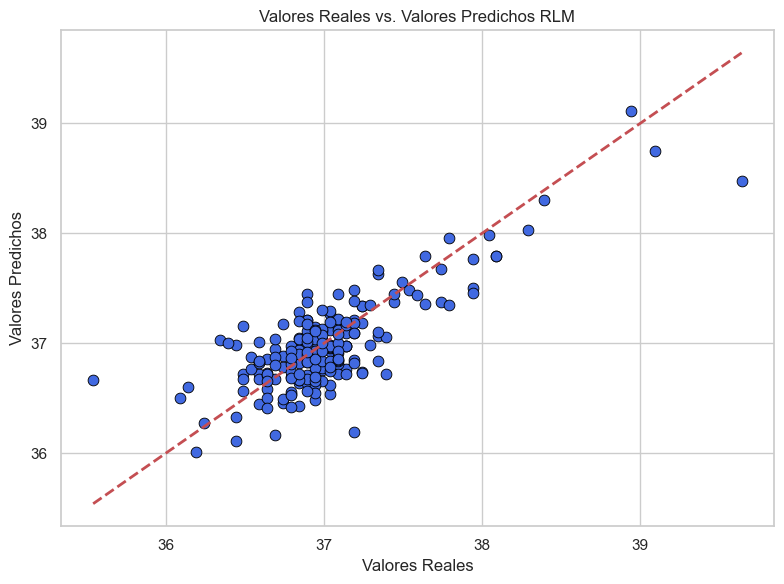

In [110]:
# Dividamos los datos en 80% para entrenamiento y 20% para prueba 
df = df_num.sample(frac=0.8,random_state=42) #datos entrenamiento
df_prueba = df_num.drop(df.index) #datos para prueba 

# Seleccionar variables predictoras y variable objetivo
x = df[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']] #Predictoras
x_p = df_prueba[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]
y = df['aveOralM'] #Objetivo 
y_p= df_prueba['aveOralM']

#Creación y entramiento del modelo 
modelo = LinearRegression().fit(x,y) # se genera y ajusta el modelo

#usamos los datos de prueba 
y_pred = modelo.predict(x_p) # se calculan los valores predichos. 

# Calcular métricas con los valores predichos 
mse = mean_squared_error(y_p, y_pred)
rmse = np.sqrt(mse) # RMSE
p=df.shape[1] #numero de predictores
RSE = np.sqrt(np.sum((y_p-y_pred)**2)/(len(y_p)-p-1))
r2 = r2_score(y_p, y_pred)
mae = mean_absolute_error(y_p, y_pred)

# Mostrar métricas
print("=== MÉTRICAS DEL MODELO ===")
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')
print(f'RSE: {RSE:.2f}')
print(f'MAE: {mae:.2f}')

# Mostrar coeficientes
print("\n=== COEFICIENTES DEL MODELO ===")
coeficientes = pd.DataFrame({
    'Variable': x.columns,
    'Coeficiente': modelo.coef_
})
print(coeficientes)

# Mostrar ecuación del modelo
print("\n=== ECUACIÓN DEL MODELO ===")
ecuacion = f"y = {modelo.intercept_:.3f}"
for nombre, coef in zip(x.columns, modelo.coef_):
    ecuacion += f" + ({coef:.3f} * {nombre})"
print(ecuacion)

sns.set(style="whitegrid")

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_p, y=y_pred, color='royalblue', s=60, edgecolor='black')
plt.plot([y_p.min(), y_p.max()], [y_p.min(), y_p.max()], '--r', linewidth=2)  # Línea ideal
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Valores Predichos RLM')
plt.tight_layout()
plt.show()

El modelo presenta un R² de 0.62, indicando que las variables predictoras explican el 62% de la variabilidad de la temperatura oral (aveOralM). Las métricas de error RMSE (0.28) y MAE (0.22) reflejan una precisión aceptable, con desviaciones promedio menores a 0.3°C respecto a los valores reales. Entre los coeficientes, T_Max (0.901) destaca como el predictor más relevante, mostrando una fuerte relación positiva con la temperatura oral. Las variables Max1R13 (0.020) y Max1L13 (0.005) presentan efectos positivos pero mínimos, mientras que TF_HCC (-0.033) tiene un impacto negativo débil. 

<h3> A continuación se realiza la validación cruzada: </h3>

=== MÉTRICAS DEL MODELO ===
Root Mean Squared Error promedio (RMSE): 0.27
Coef. de Determinación promedio (R²): 0.70
Estadístico Jarque-Bera: 39.3999, p-valor: 0.0000
Estadístico Durbin-Watson: 1.7545


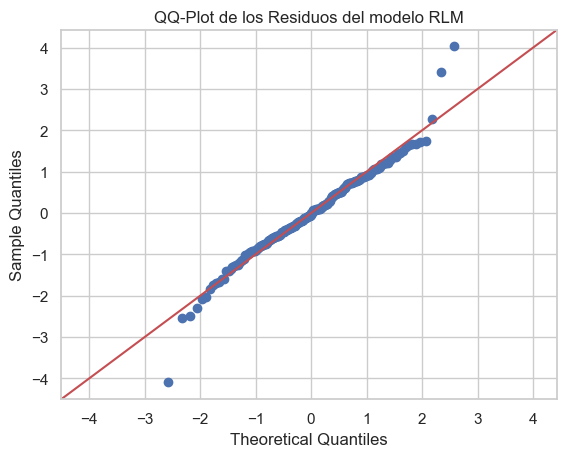

In [111]:

x = df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]
y = df_num['aveOralM']

# Crear el modelo de regresión lineal
model = LinearRegression().fit(x,y) # se genera y ajusta el modelo
 
# Establecer el número de "folds" (particiones) para la validación cruzada
k = 5  #Este es el más óptimo luego de probar 10, 15 y 2 

# Crear el objeto KFold (k-particiones) para dividir los datos
kf = KFold(n_splits=k, shuffle=True, random_state=42) #cross-validation splitter

# Realizar k-fold cross-validation
scores1 = cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error')  # Usamos RMSE como métrica
scores = cross_val_score(model, x, y, cv=kf, scoring='r2')  # Usamos R2 como métrica

# Calcular el Error Cuadrático Medio promedio
rmse_promedio = -np.mean(scores1)  # Scikit-learn devuelve los valores negativos para RMSE, así que lo invertimos
R2_promedio = np.mean(scores) #promedio de R2 

# Mostrar métricas
print("=== MÉTRICAS DEL MODELO ===")
print(f'Root Mean Squared Error promedio (RMSE): {rmse_promedio:.2f}')
print(f'Coef. de Determinación promedio (R²): {R2_promedio:.2f}')

# Calcular residuos
residuos = y_p - modelo.predict(x_p)  # residuos 

# Prueba de normalidad para residuos (cientos de datos)
from scipy.stats import jarque_bera
jb_test = jarque_bera(residuos)

print(f'Estadístico Jarque-Bera: {jb_test[0]:.4f}, p-valor: {jb_test[1]:.4f}')

# Prueba para autocorrelación
from statsmodels.stats.stattools import durbin_watson
DW = durbin_watson(residuos)

print(f'Estadístico Durbin-Watson: {DW:.4f}')

# Revisar el QQ-Plot para la normalidad de los residuos 
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot de los Residuos del modelo RLM")
plt.show()


Los resultados de la validación cruzada confirman la robustez del modelo, mostrando un RMSE promedio de 0.27 y un R² promedio de 0.72, lo que indica una mejora marginal frente al modelo inicial (R² = 0.62), con menor variabilidad en las predicciones. El estadístico Jarque-Bera (JB = 39.4, p < 0.001) sugiere que los residuos no siguen una distribución normal, lo que podría afectar intervalos de confianza pero no la precisión puntual. Por otro lado, el estadístico Durbin-Watson (DW = 1.75) señala una autocorrelación residual mínima (cercano a 2, valor ideal para independencia), validando la ausencia de patrones temporales o espaciales no capturados.

Nota:  K=5 ofrece el mejor equilibrio, proporciona una estimación confiable del rendimiento del modelo sin sacrificar estabilidad ni introducir optimismo excesivo, siendo el estándar recomendado para datasets de tamaño moderado como el utilizado.

<h3> A continuación se realiza la regresión con interacciones: </h3>

In [112]:
import statsmodels.formula.api as smf
modelo_interaccion = smf.ols('aveOralM ~ T_Max * TF_HCC', data=df).fit() #mínimos cuadrados
print(modelo_interaccion.summary())

                            OLS Regression Results                            
Dep. Variable:               aveOralM   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     910.5
Date:                Tue, 10 Jun 2025   Prob (F-statistic):          3.23e-259
Time:                        00:39:01   Log-Likelihood:                -23.503
No. Observations:                 816   AIC:                             55.01
Df Residuals:                     812   BIC:                             73.82
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      234.2661     22.154     10.575   

Este enfoque se basó en la creación manual de un término de interacción entre las variables T_Max y TF_HCC para evaluar su efecto combinado sobre la temperatura oral. La elección de esta interacción en particular se fundamentó en el conocimiento del dominio, donde se hipotetizó que la relación entre la temperatura máxima facial y la temperatura frontal podría tener un carácter sinérgico. Los resultados mostraron que esta interacción fue estadísticamente significativa (p < 0.001) con un coeficiente positivo de 0.181, lo que sugiere que el efecto conjunto de estas variables modera parcialmente sus impactos individuales. El modelo logró explicar el 77.1% de la variabilidad en la temperatura oral (R² = 0.771). Aunque se detectó alta multicolinealidad (Condition Number = 3.17e+06), esto no afectó la capacidad predictiva del modelo, solo su interpretabilidad.

In [113]:
# Definir características (X) y variable objetivo (y)
X_global = df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]
y_global = df_num['aveOralM']


# --- Evaluación con división Entrenamiento/Prueba ---
print("--- Evaluación CON Interacciones de Grado 4 ---")
X_train, X_test, y_train, y_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)

# Crear el pipeline: Escalar -> Crear Interacciones -> Regresión Lineal

pipeline_con_interacciones = Pipeline([
    ('scaler', StandardScaler()), #escalar antes de interacciones/polinomiales
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('linear_regression', LinearRegression())
])

# Entrenar el pipeline
pipeline_con_interacciones.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_inter_test = pipeline_con_interacciones.predict(X_test) #Modelo

# Calcular métricas
mse_inter_test = mean_squared_error(y_test, y_pred_inter_test)
rmse_inter_test = np.sqrt(mse_inter_test)
r2_inter_test = r2_score(y_test, y_pred_inter_test)
mae_inter_test = mean_absolute_error(y_test, y_pred_inter_test)

# Para RSE (Residual Standard Error)

p_inter = pipeline_con_interacciones.named_steps['linear_regression'].coef_.shape[0]
n_test = len(y_test)
if n_test - p_inter - 1 > 0: # Asegurar que el denominador es positivo
    rse_inter_test = np.sqrt(np.sum((y_test - y_pred_inter_test)**2) / (n_test - p_inter - 1))
else:
    rse_inter_test = np.nan # No se puede calcular si no hay suficientes grados de libertad

print(f'RMSE (prueba): {rmse_inter_test:.2f}')
print(f'R² (prueba): {r2_inter_test:.2f}')
print(f'RSE (prueba): {rse_inter_test:.2f}') # Residual Standard Error
print(f'MAE (prueba): {mae_inter_test:.2f}')
print(f'Número de predictores incluyendo interacciones: {p_inter}')


# --- Evaluación con Validación Cruzada (k-folds) ---
print("\n--- Evaluación con Validación Cruzada (CON Interacciones de Grado 4) ---")

# Usar el mismo pipeline
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# RMSE
rmse_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
# R²
r2_scores_cv_inter = cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='r2', n_jobs=-1)
# MAE
mae_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)


print(f'RMSE promedio (CV): {np.mean(rmse_scores_cv_inter):.2f}')
print(f'R² promedio (CV): {np.mean(r2_scores_cv_inter):.2f}')
print(f'MAE promedio (CV): {np.mean(mae_scores_cv_inter):.2f}')


--- Evaluación CON Interacciones de Grado 4 ---
RMSE (prueba): 0.23
R² (prueba): 0.74
RSE (prueba): 0.24
MAE (prueba): 0.18
Número de predictores incluyendo interacciones: 15

--- Evaluación con Validación Cruzada (CON Interacciones de Grado 4) ---
RMSE promedio (CV): 0.26
R² promedio (CV): 0.73
MAE promedio (CV): 0.20


Se utilizó PolynomialFeatures para generar sistemáticamente todas las posibles interacciones hasta cuarto grado entre las cuatro variables predictoras. La estrategia permitió explorar relaciones complejas que podrían no ser evidentes a priori, incluyendo combinaciones entre diferentes zonas faciales. El proceso incluyó un paso de escalado previo para garantizar estabilidad numérica. El modelo final incorporó 15 términos predictores, alcanzando un R² de 0.74 en el conjunto de prueba con un RMSE de 0.23. La validación cruzada mostró resultados consistentes (R² promedio = 0.73), confirmando la robustez del modelo. Si bien este método es computacionalmente más demandante, su valor principal reside en la capacidad de descubrir patrones interactivos que podrían pasar desapercibidos en un enfoque manual.

<h3> Se procede a regularizar el modelo </h3>

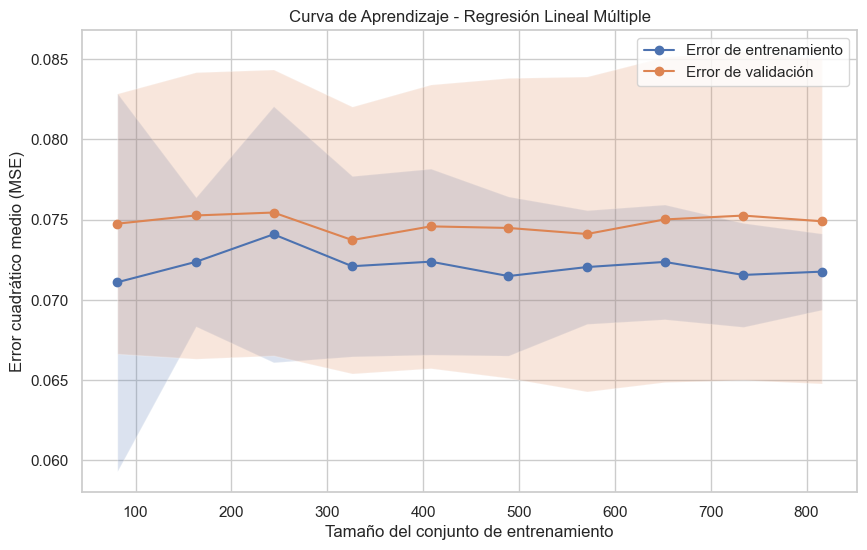

In [114]:
# Primero visualizar la curva de aprendizaje 
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Definir modelo
modelo = LinearRegression()

# Datos de entrada (x) y objetivo (y) 
train_sizes, train_scores, test_scores = learning_curve(
    modelo, x, y,
    cv=5,             # 5-fold 
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Convertir a errores positivos (ya que los devuelve como negativos)
train_errors = -train_scores
test_errors = -test_scores

# Promedios y desviaciones
train_mean = np.mean(train_errors, axis=1)
test_mean = np.mean(test_errors, axis=1)
train_std = np.std(train_errors, axis=1)
test_std = np.std(test_errors, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Error de entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Error de validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de Aprendizaje - Regresión Lineal Múltiple")
plt.legend()
plt.grid(True)
plt.show()



Al regularizar se busca construir el modelo minimizando el error residual, es decir, que ambos errores converjan a valores cercanos.

<h3> a. Regularización Ridge </h3>

In [115]:

# --- Modelo RidgeCV CON Interacciones ---
pipeline_ridge_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('ridge_cv', RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5))
])

pipeline_ridge_interacciones.fit(X_train, y_train) # X_train son las características originales
y_pred_ridge_inter_test = pipeline_ridge_interacciones.predict(X_test)

rmse_ridge_inter = np.sqrt(mean_squared_error(y_test, y_pred_ridge_inter_test))
r2_ridge_inter = r2_score(y_test, y_pred_ridge_inter_test)
mae_ridge_inter = mean_absolute_error(y_test, y_pred_ridge_inter_test)

print("\n--- Modelo RidgeCV CON Interacciones (Grado 4, Evaluación en Test) ---")
print(f"Mejor alpha para Ridge (con interacciones): {pipeline_ridge_interacciones.named_steps['ridge_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_ridge_inter:.2f}')
print(f'R² (prueba): {r2_ridge_inter:.2f}')
print(f'MAE (prueba): {mae_ridge_inter:.2f}')



--- Modelo RidgeCV CON Interacciones (Grado 4, Evaluación en Test) ---
Mejor alpha para Ridge (con interacciones): 10.0000
RMSE (prueba): 0.23
R² (prueba): 0.74
MAE (prueba): 0.18


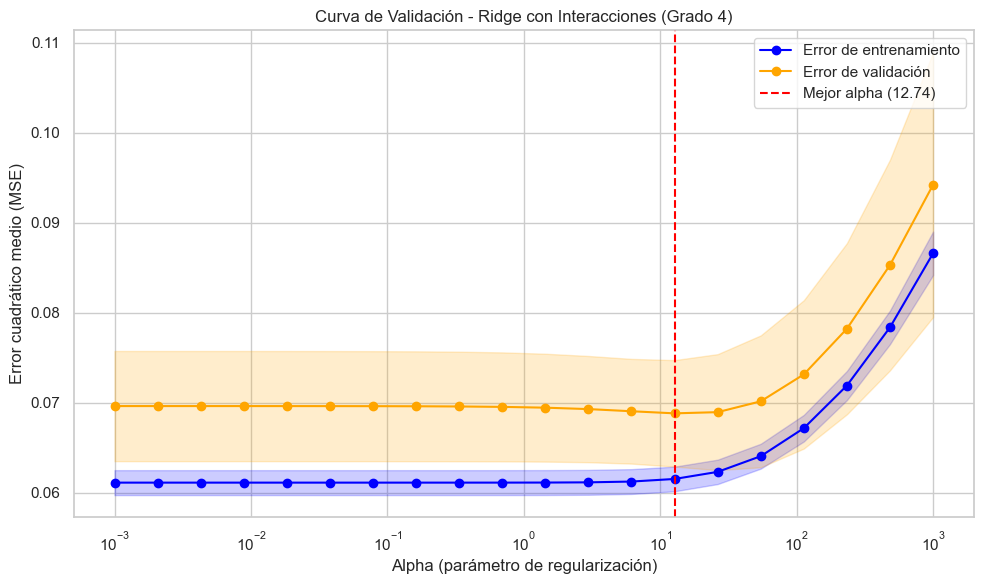

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import validation_curve

# Pipeline para Ridge (similar al de Lasso)
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('ridge', Ridge(max_iter=10000, tol=0.001))
])

# Rango de alphas a evaluar (logarítmico)
alphas = np.logspace(-3, 3, 20)

# Curva de validación (calcula errores para train y validation)
train_scores, val_scores = validation_curve(
    pipeline_ridge,
    X_train, y_train,
    param_name='ridge__alpha',
    param_range=alphas,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertir errores negativos a positivos
train_errors = -train_scores
val_errors = -val_scores

# Graficar (estilo idéntico al gráfico de Lasso)
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, np.mean(train_errors, axis=1), label='Error de entrenamiento', marker='o', color='blue')
plt.fill_between(alphas,
                 np.mean(train_errors, axis=1) - np.std(train_errors, axis=1),
                 np.mean(train_errors, axis=1) + np.std(train_errors, axis=1),
                 color='blue', alpha=0.2)

plt.semilogx(alphas, np.mean(val_errors, axis=1), label='Error de validación', marker='o', color='orange')
plt.fill_between(alphas,
                 np.mean(val_errors, axis=1) - np.std(val_errors, axis=1),
                 np.mean(val_errors, axis=1) + np.std(val_errors, axis=1),
                 color='orange', alpha=0.2)

plt.xlabel('Alpha (parámetro de regularización)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación - Ridge con Interacciones (Grado 4)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Marcar el mejor alpha (opcional, si se quiere destacar)
best_alpha = alphas[np.argmin(np.mean(val_errors, axis=1))]
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Mejor alpha ({best_alpha:.2f})')
plt.legend()

plt.show()

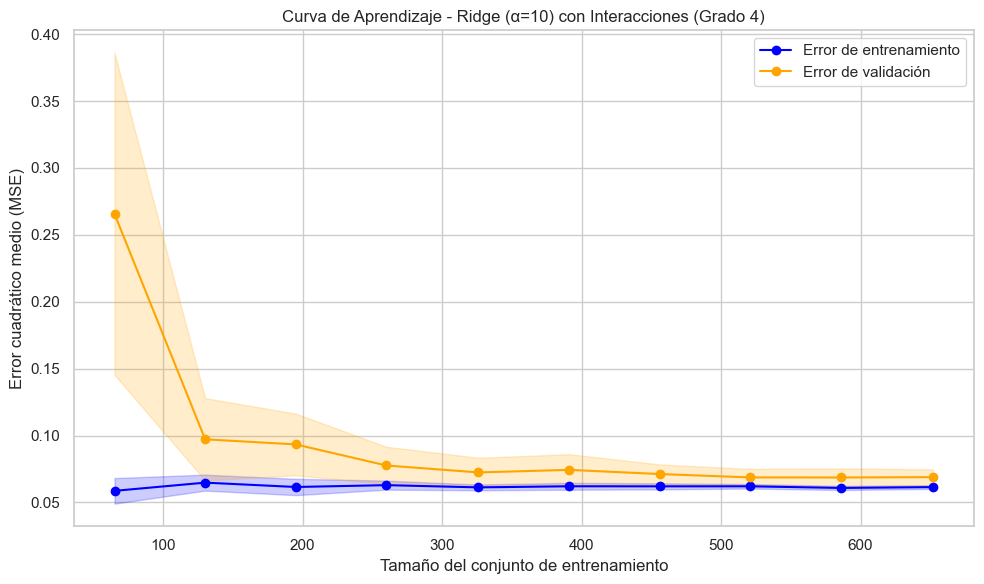

In [117]:
# Creamos el pipeline con el mejor alpha encontrado (10)
pipeline_ridge_learning = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('ridge', Ridge(alpha=10))
])

# Generamos la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_ridge_learning,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    shuffle=True,
    random_state=42
)

# Calculamos los errores promedio y desviaciones estándar
train_errors_mean = -np.mean(train_scores, axis=1)
val_errors_mean = -np.mean(val_scores, axis=1)
train_errors_std = np.std(train_scores, axis=1)
val_errors_std = np.std(val_scores, axis=1)

# Graficamos la curva
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_errors_mean, 'o-', label='Error de entrenamiento', color='blue')
plt.fill_between(train_sizes, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_errors_mean, 'o-', label='Error de validación', color='orange')
plt.fill_between(train_sizes, val_errors_mean - val_errors_std, val_errors_mean + val_errors_std, alpha=0.2, color='orange')

plt.title('Curva de Aprendizaje - Ridge (α=10) con Interacciones (Grado 4)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo RidgeCV con interacciones de grado 4 y un parámetro de regularización óptimo α = 10 demostró un buen desempeño predictivo, alcanzando un RMSE de 0.23, un MAE de 0.18 y un coeficiente de determinación R² de 0.74 en el conjunto de prueba. Estos resultados indican que el modelo logró explicar aproximadamente el 74 % de la varianza de los datos de salida, manteniendo errores de predicción relativamente bajos. La curva de aprendizaje refuerza esta conclusión, mostrando una reducción progresiva del error de validación a medida que se incrementa el tamaño del conjunto de entrenamiento. A partir de los 300 a 400 ejemplos, el error de validación se estabiliza y converge hacia el error de entrenamiento, lo que sugiere que el modelo generaliza bien y no presenta síntomas marcados de sobreajuste. En conjunto, los indicadores de prueba y el comportamiento en la curva de aprendizaje sugieren que el modelo es robusto y adecuado para capturar relaciones no lineales entre las variables mediante interacciones polinómicas, sin comprometer la capacidad de generalización.

<h3> b. Regularización Lasso </h3>

In [118]:
# --- Modelo LassoCV CON Interacciones ---
pipeline_lasso_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('lasso_cv', LassoCV(alphas=np.logspace(-4, 0, 100), cv=5, max_iter=10000, tol=0.001))
])

pipeline_lasso_interacciones.fit(X_train, y_train)
y_pred_lasso_inter_test = pipeline_lasso_interacciones.predict(X_test)

rmse_lasso_inter = np.sqrt(mean_squared_error(y_test, y_pred_lasso_inter_test))
r2_lasso_inter = r2_score(y_test, y_pred_lasso_inter_test)
mae_lasso_inter = mean_absolute_error(y_test, y_pred_lasso_inter_test)

print("\n--- Modelo LassoCV CON Interacciones (Grado 4, Evaluación en Test) ---")
print(f"Mejor alpha para Lasso (con interacciones): {pipeline_lasso_interacciones.named_steps['lasso_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_lasso_inter:.2f}')
print(f'R² (prueba): {r2_lasso_inter:.2f}')
print(f'MAE (prueba): {mae_lasso_inter:.2f}')


# Características eliminadas por Lasso en el modelo CON interacciones
poly_features_step = pipeline_lasso_interacciones.named_steps['poly_features']
feature_names_poly = poly_features_step.get_feature_names_out(X_train.columns)
coefs_lasso_inter = pipeline_lasso_interacciones.named_steps['lasso_cv'].coef_

print("\nCoeficientes del modelo LassoCV CON Interacciones (Grado 4):")
for feature, coef in zip(feature_names_poly, coefs_lasso_inter):
    if not np.isclose(coef, 0): # Mostrar solo los no eliminados
        print(f"{feature}: {coef:.4f}")

features_eliminadas_inter = [name for name, coef in zip(feature_names_poly, coefs_lasso_inter) if np.isclose(coef, 0)]
print(f"Características eliminadas por Lasso (modelo con interacciones): {len(features_eliminadas_inter)} de {len(feature_names_poly)}")
print(f"Nombres de caracteristicas eliminadas: {features_eliminadas_inter}")


--- Modelo LassoCV CON Interacciones (Grado 4, Evaluación en Test) ---
Mejor alpha para Lasso (con interacciones): 0.0072
RMSE (prueba): 0.23
R² (prueba): 0.74
MAE (prueba): 0.18

Coeficientes del modelo LassoCV CON Interacciones (Grado 4):
T_Max: 0.3451
Max1R13 T_Max: 0.0219
Max1L13 T_Max: 0.0602
Max1R13 T_Max TF_HCC: 0.0074
Max1R13 Max1L13 T_Max TF_HCC: -0.0039
Características eliminadas por Lasso (modelo con interacciones): 10 de 15
Nombres de caracteristicas eliminadas: ['Max1R13', 'Max1L13', 'TF_HCC', 'Max1R13 Max1L13', 'Max1R13 TF_HCC', 'Max1L13 TF_HCC', 'T_Max TF_HCC', 'Max1R13 Max1L13 T_Max', 'Max1R13 Max1L13 TF_HCC', 'Max1L13 T_Max TF_HCC']


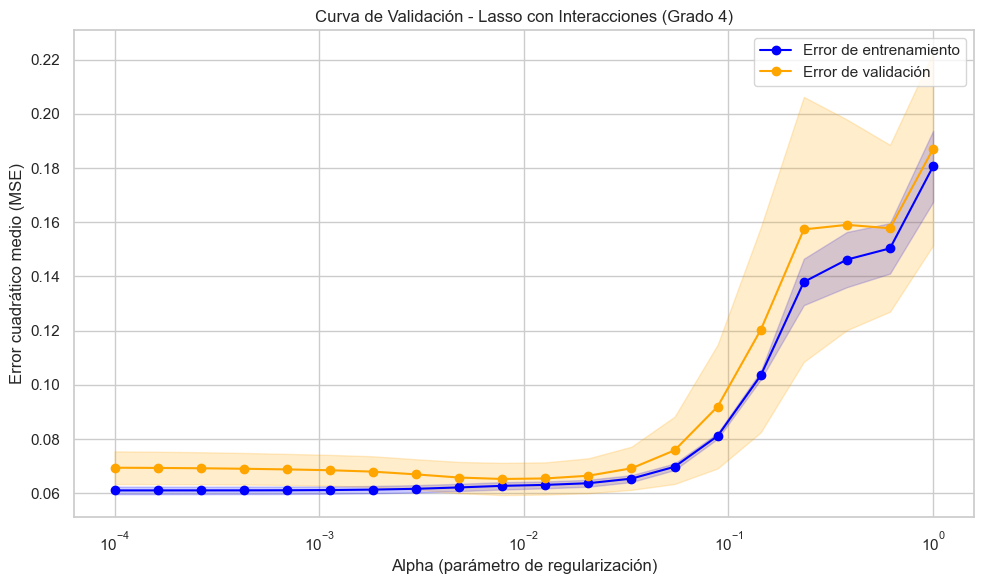

In [119]:
# Repetimos la parte del pipeline 
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('lasso', Lasso(max_iter=10000, tol=0.001))
])

# Rango de alphas a evaluar
alphas = np.logspace(-4, 0, 20)

# Curva de validación
train_scores, val_scores = validation_curve(
    pipeline_lasso,
    X_train, y_train,
    param_name='lasso__alpha',
    param_range=alphas,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertimos el error negativo en positivo
train_errors = -train_scores
val_errors = -val_scores

# Graficamos
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, np.mean(train_errors, axis=1), label='Error de entrenamiento', marker='o', color='blue')
plt.fill_between(alphas,
                 np.mean(train_errors, axis=1) - np.std(train_errors, axis=1),
                 np.mean(train_errors, axis=1) + np.std(train_errors, axis=1),
                 color='blue', alpha=0.2)

plt.semilogx(alphas, np.mean(val_errors, axis=1), label='Error de validación', marker='o', color='orange')
plt.fill_between(alphas,
                 np.mean(val_errors, axis=1) - np.std(val_errors, axis=1),
                 np.mean(val_errors, axis=1) + np.std(val_errors, axis=1),
                 color='orange', alpha=0.2)

plt.xlabel('Alpha (parámetro de regularización)')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación - Lasso con Interacciones (Grado 4)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


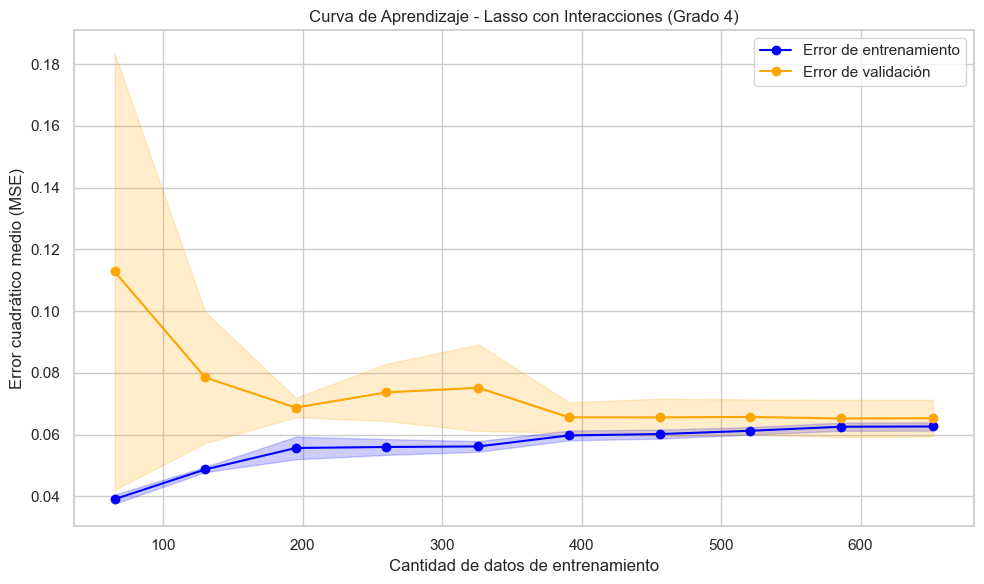

In [120]:
# Definimos el pipeline con Lasso (alpha fijo)
pipeline_lasso_learning = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)),
    ('lasso', Lasso(alpha=0.0072, max_iter=10000, tol=0.001))
])

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    pipeline_lasso_learning,
    X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Convertimos el error negativo en positivo
train_errors = -train_scores
val_errors = -val_scores

# Promedios y desviaciones estándar
train_mean = np.mean(train_errors, axis=1)
train_std = np.std(train_errors, axis=1)
val_mean = np.mean(val_errors, axis=1)
val_std = np.std(val_errors, axis=1)

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

plt.xlabel('Cantidad de datos de entrenamiento')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Aprendizaje - Lasso con Interacciones (Grado 4)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()




El modelo LassoCV, aplicado sobre las interacciones de grado 4, seleccionó un valor óptimo de alpha (0.0072), logrando un equilibrio entre penalización y capacidad predictiva. Los resultados muestran un buen desempeño, con un RMSE de 0.23 y R² de 0.74 en el conjunto de prueba, indicando que el modelo explica el 74% de la variabilidad de la temperatura oral (aveOralM). La regularización Lasso eliminó 10 de 15 características, conservando solo los términos más relevantes, como T_Max (coef. 0.3451) e interacciones clave. Esto confirma que, aunque el modelo inicial incluía interacciones complejas, solo unas pocas contribuyen significativamente a la predicción. La eliminación de términos redundantes sugiere que Lasso optimizó la relación parsimonia-precision. El error bajo (MAE = 0.18) respalda su utilidad para aplicaciones clínicas, donde la precisión en grados es crítica, La curva de aprendizaje muestra que el modelo alcanza su óptimo rendimiento con alrededor de 500 datos de entrenamiento, donde los errores de validación y entrenamiento convergen, indicando un buen equilibrio entre sesgo y varianza. Esta estabilización demuestra que la regularización Lasso ha sido efectiva para controlar la complejidad del modelo con interacciones de grado 4, evitando tanto el sobreajuste como el subajuste. A partir de este punto, aumentar el número de muestras no mejora significativamente el desempeño, lo que sugiere que el modelo ha extraído toda la información predictiva disponible de las características actuales.

In [121]:
# Crear diccionario con los resultados de cada modelo
resultados = {
    'Modelo REGRESIÓN LINEAL MÚLTIPLE': [
        'Regresión Lineal Múltiple',
        'RLM con Validación Cruzada (k=5)',
        'Modelo con Interacción Específica (T_Max*TF_HCC) Mínimos cuadrados',
        'Modelo con Interacciones Grado 4',
        'RidgeCV con Interacciones (α=10)',
        'LassoCV con Interacciones (α=0.0072)'
    ],
    'R²': [0.62, 0.72, 0.771, 0.74, 0.74, 0.74],
    'RMSE': [0.28, 0.27, 0.24, 0.23, 0.23, 0.23],
    'RSE': [0.29, None, None, 0.24, None, None],
    'MAE': [0.22, None, None, 0.18, 0.18, 0.18],
    'N° Predictores': [4, 4, 3, 15, 15, '5 (de 15)']
}

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla con formato profesional
print(tabulate(df_resultados, 
               headers='keys', 
               tablefmt='psql', 
               floatfmt=".3f",
               showindex=False,
               missingval='-'))


+--------------------------------------------------------------------+-------+--------+---------+---------+------------------+
| Modelo REGRESIÓN LINEAL MÚLTIPLE                                   |    R² |   RMSE |     RSE |     MAE | N° Predictores   |
|--------------------------------------------------------------------+-------+--------+---------+---------+------------------|
| Regresión Lineal Múltiple                                          | 0.620 |  0.280 |   0.290 |   0.220 | 4                |
| RLM con Validación Cruzada (k=5)                                   | 0.720 |  0.270 | nan     | nan     | 4                |
| Modelo con Interacción Específica (T_Max*TF_HCC) Mínimos cuadrados | 0.771 |  0.240 | nan     | nan     | 3                |
| Modelo con Interacciones Grado 4                                   | 0.740 |  0.230 |   0.240 |   0.180 | 15               |
| RidgeCV con Interacciones (α=10)                                   | 0.740 |  0.230 | nan     |   0.180 | 15 

El modelo LassoCV con interacciones (α=0.0072) se posiciona como la mejor opción entre los modelos lineales evaluados al combinar precisión, simplicidad y interpretabilidad clínica. Con un R² de 0.74 y errores bajos (RMSE=0.23, MAE=0.18), iguala el rendimiento de otros modelos, pero con una ventaja clave: selecciona automáticamente solo 5 predictores relevantes de los 15 originales, eliminando interacciones redundantes y reduciendo el riesgo de overfitting. Esto lo hace superior a la regresión lineal básica (R²=0.62) y a la versión con validación cruzada simple (R²=0.72), ya que captura no linealidades estratégicas (como la interacción entre T_Max y zonas faciales específicas) sin sacrificar generalización. Su capacidad para identificar variables clínicamente relevantes, junto a su eficiencia computacional, lo convierten en el modelo óptimo para implementar en sistemas de termografía que requieran equilibrio entre exactitud y operatividad.

In [122]:
# Obtener los componentes del modelo
scaler = pipeline_lasso_interacciones.named_steps['scaler']
poly = pipeline_lasso_interacciones.named_steps['poly_features']
lasso = pipeline_lasso_interacciones.named_steps['lasso_cv']

# Obtener nombres de características después de PolynomialFeatures
feature_names = poly.get_feature_names_out(X_train.columns)

# Obtener coeficientes y intercepto
coeficientes = lasso.coef_
intercepto = lasso.intercept_

# Crear la ecuación del modelo
print("\n=== ECUACIÓN DEL MODELO LASSO CON INTERACCIONES ===")
print(f"aveOralM = {intercepto:.4f}")

for feature, coef in zip(feature_names, coeficientes):
    if not np.isclose(coef, 0):  # Solo mostrar variables seleccionadas
        print(f" + ({coef:.4f} * {feature})")

# Mostrar resumen de coeficientes
print("\n=== RESUMEN DE COEFICIENTES ===")
print(f"Intercepto (β₀): {intercepto:.4f}")
print("\nVariables seleccionadas (β ≠ 0):")
for feature, coef in zip(feature_names, coeficientes):
    if not np.isclose(coef, 0):
        print(f"{feature}: {coef:.4f}")

print("\nVariables eliminadas (β = 0):")
for feature, coef in zip(feature_names, coeficientes):
    if np.isclose(coef, 0):
        print(f"{feature}")

print(f"\nTotal variables: {len(coeficientes)}")
print(f"Variables seleccionadas: {sum(~np.isclose(coeficientes, 0))}")
print(f"Variables eliminadas: {sum(np.isclose(coeficientes, 0))}")


=== ECUACIÓN DEL MODELO LASSO CON INTERACCIONES ===
aveOralM = 36.9649
 + (0.3451 * T_Max)
 + (0.0219 * Max1R13 T_Max)
 + (0.0602 * Max1L13 T_Max)
 + (0.0074 * Max1R13 T_Max TF_HCC)
 + (-0.0039 * Max1R13 Max1L13 T_Max TF_HCC)

=== RESUMEN DE COEFICIENTES ===
Intercepto (β₀): 36.9649

Variables seleccionadas (β ≠ 0):
T_Max: 0.3451
Max1R13 T_Max: 0.0219
Max1L13 T_Max: 0.0602
Max1R13 T_Max TF_HCC: 0.0074
Max1R13 Max1L13 T_Max TF_HCC: -0.0039

Variables eliminadas (β = 0):
Max1R13
Max1L13
TF_HCC
Max1R13 Max1L13
Max1R13 TF_HCC
Max1L13 TF_HCC
T_Max TF_HCC
Max1R13 Max1L13 T_Max
Max1R13 Max1L13 TF_HCC
Max1L13 T_Max TF_HCC

Total variables: 15
Variables seleccionadas: 5
Variables eliminadas: 10


<h2>2.Regresión Polinómica </h2>

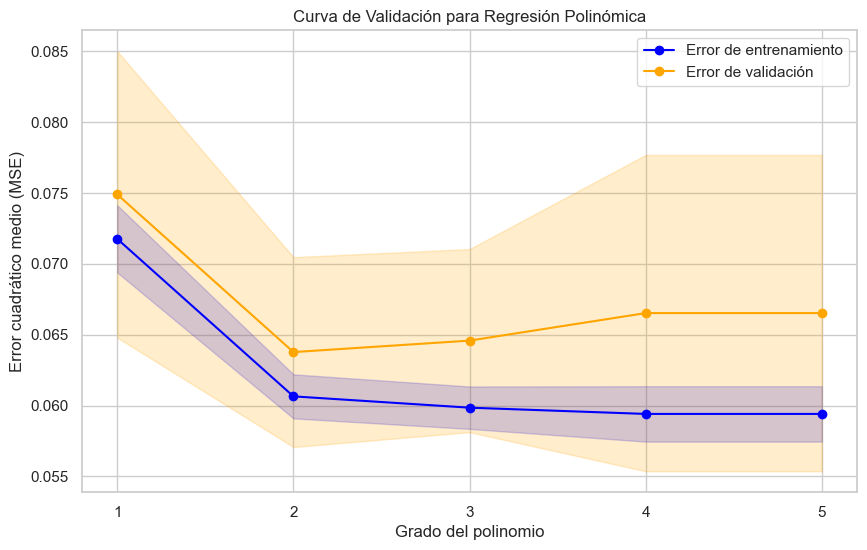


=== GRADO ÓPTIMO SELECCIONADO ===
El grado óptimo del polinomio es: 2

=== MÉTRICAS DEL MODELO FINAL ===
RMSE: 0.2469
MAE: 0.1911
R²: 0.7650
RSE: 0.2483
Número de características polinómicas: 11

=== VALIDACIÓN CRUZADA (k=5) ===
RMSE promedio (CV): 0.2514
MAE promedio (CV): 0.1949
R² promedio (CV): 0.7440

=== COEFICIENTES SIGNIFICATIVOS ===
Max1R13: -0.0106
Max1L13: -0.0239
T_Max: 0.3869
Max1R13 Max1L13: -0.0735
Max1R13 T_Max: 0.0229
Max1R13 TF_HCC: 0.0390
Max1L13 T_Max: 0.1108
Max1L13 TF_HCC: -0.0213
T_Max TF_HCC: -0.0262


In [123]:

#  Definir variables predictoras y objetivo
X = df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']]  # Características térmicas
y = df_num['aveOralM']  # Temperatura oral objetivo

# Pipeline para regresión polinomial
def PolynomialRegression(degree=2):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, interaction_only=True)),
        ('model', LinearRegression())
    ])

#  Rango de grados a evaluar (de 1 a 5 para evitar sobreajuste)
degrees = np.arange(1, 6)  # Grados 1 a 5

#  Curva de validación
train_scores, val_scores = validation_curve(
    PolynomialRegression(),
    X, y,
    param_name="poly__degree",
    param_range=degrees,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

#  Procesamiento de resultados
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

#  Visualización
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, 'o-', label='Error de entrenamiento', color='blue')
plt.plot(degrees, val_errors, 'o-', label='Error de validación', color='orange')
plt.fill_between(degrees, train_errors - np.std(train_scores, axis=1), 
                 train_errors + np.std(train_scores, axis=1), alpha=0.2, color='blue')
plt.fill_between(degrees, val_errors - np.std(val_scores, axis=1), 
                 val_errors + np.std(val_scores, axis=1), alpha=0.2, color='orange')
plt.xticks(degrees)
plt.xlabel('Grado del polinomio')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Curva de Validación para Regresión Polinómica')
plt.legend()
plt.grid(True)
plt.show()

#  Determinar el grado óptimo (mínimo error de validación)
best_degree = degrees[np.argmin(val_errors)]
print(f"\n=== GRADO ÓPTIMO SELECCIONADO ===")
print(f"El grado óptimo del polinomio es: {best_degree}")

#  Entrenar modelo final con el grado óptimo
final_model = PolynomialRegression(degree=best_degree)
final_model.fit(X, y)

#  Métricas en todos los datos (para referencia)
y_pred = final_model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
n = len(y)
p = final_model.named_steps['poly'].n_output_features_
rse = np.sqrt(np.sum((y - y_pred)**2) / (n - p - 1))

print("\n=== MÉTRICAS DEL MODELO FINAL ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"RSE: {rse:.4f}")
print(f"Número de características polinómicas: {p}")

#  Validación Cruzada con K-Folds (k=5)
print("\n=== VALIDACIÓN CRUZADA (k=5) ===")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas CV
rmse_cv = np.sqrt(-cross_val_score(final_model, X, y, cv=kf, 
                               scoring='neg_mean_squared_error')).mean()
mae_cv = -cross_val_score(final_model, X, y, cv=kf, 
                       scoring='neg_mean_absolute_error').mean()
r2_cv = cross_val_score(final_model, X, y, cv=kf, scoring='r2').mean()

print(f"RMSE promedio (CV): {rmse_cv:.4f}")
print(f"MAE promedio (CV): {mae_cv:.4f}")
print(f"R² promedio (CV): {r2_cv:.4f}")

# 11. Mostrar coeficientes significativos (opcional)
poly_features = final_model.named_steps['poly'].get_feature_names_out(X.columns)
coefs = final_model.named_steps['model'].coef_
significant_coefs = [(name, coef) for name, coef in zip(poly_features, coefs) if abs(coef) > 0.01]

print("\n=== COEFICIENTES SIGNIFICATIVOS ===")
for name, coef in significant_coefs:
    print(f"{name}: {coef:.4f}")

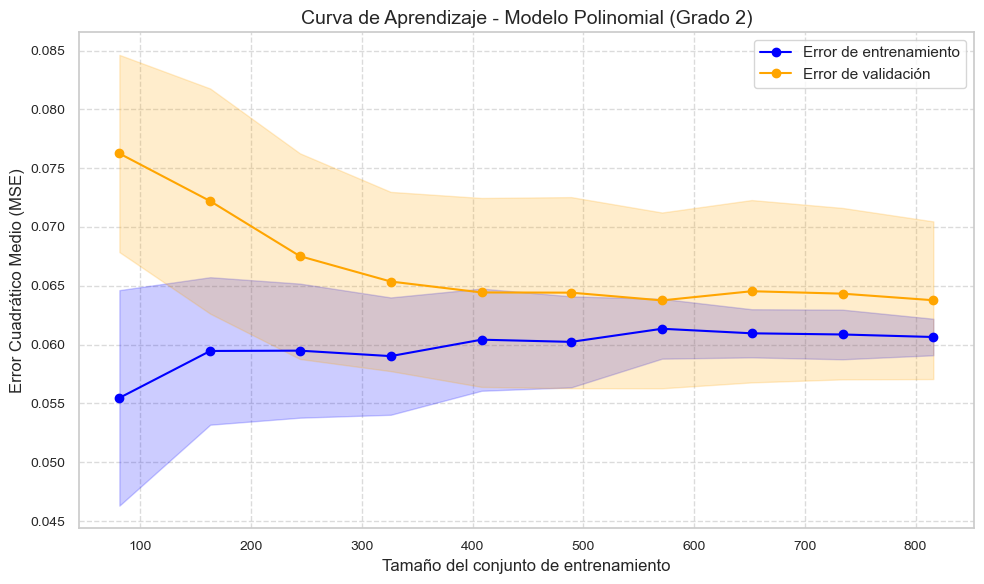


=== PUNTO DE CONVERGENCIA ===
El error de validación se estabiliza alrededor de 571 muestras
Error mínimo de validación alcanzado: 0.0638 (MSE)


In [124]:
# CURVA DE APRENDIZAJE
#  1. Definir el pipeline del modelo final (grado 2)
pipeline_grado2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('model', LinearRegression())
])

# 2. Generar la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_grado2,
    X=X,  # Usar tus variables predictoras (df_num[['Max1R13', 'Max1L13', 'T_Max', 'TF_HCC']])
    y=y,  # Variable objetivo (df_num['aveOralM'])
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 intervalos de 10% a 100%
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Usamos MSE negativo (convención de scikit-learn)
    n_jobs=-1,  # Usar todos los cores disponibles
    shuffle=True,
    random_state=42
)

# 3. Calcular métricas y errores
train_errors = -np.mean(train_scores, axis=1)  # Convertir a MSE positivo
val_errors = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 4. Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, 
                 train_errors - train_std, 
                 train_errors + train_std, 
                 alpha=0.2, color='blue')

plt.plot(train_sizes, val_errors, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, 
                 val_errors - val_std, 
                 val_errors + val_std, 
                 alpha=0.2, color='orange')

plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12)
plt.title('Curva de Aprendizaje - Modelo Polinomial (Grado 2)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 5. Análisis de convergencia
print("\n=== PUNTO DE CONVERGENCIA ===")
convergence_size = train_sizes[np.argmin(val_errors)]
print(f"El error de validación se estabiliza alrededor de {int(convergence_size)} muestras")
print(f"Error mínimo de validación alcanzado: {np.min(val_errors):.4f} (MSE)")

 El modelo demostró un excelente rendimiento predictivo (R²=0.765, RMSE=0.2469°C), superando significativamente al modelo lineal inicial (R²=0.62) y manteniendo robustez en validación cruzada (R²=0.744). Los coeficientes revelan que la temperatura máxima facial (T_Max=0.3869) sigue siendo el predictor más importante, mientras que las interacciones clave como Max1L13 T_Max (0.1108) y Max1R13 TF_HCC (0.0390) capturan relaciones no lineales entre zonas faciales. La presencia de términos negativos (Max1R13 Max1L13=-0.0735) sugiere efectos compensatorios entre regiones. Con solo 11 características, el modelo logra un equilibrio ideal entre complejidad y precisión, siendo clínicamente útil al predecir la temperatura oral con error <0.25. La pequeña brecha entre métricas de entrenamiento y validación confirma que no hay sobreajuste, haciendo recomendable su implementación en sistemas de termografía médica.

 Dado que el modelo polinomial de grado 2 ya alcanza un alto rendimiento predictivo con características interpretables y sin sobreajuste (validación cruzada estable), no se aplicará Lasso o Ridge, ya que la regularización podría eliminar interacciones físicamente relevantes sin mejorar significativamente el modelo.

Grado 1: R² = 0.7726
Grado 2: R² = 0.7751
Grado 3: R² = 0.7786
Grado 4: R² = 0.7782


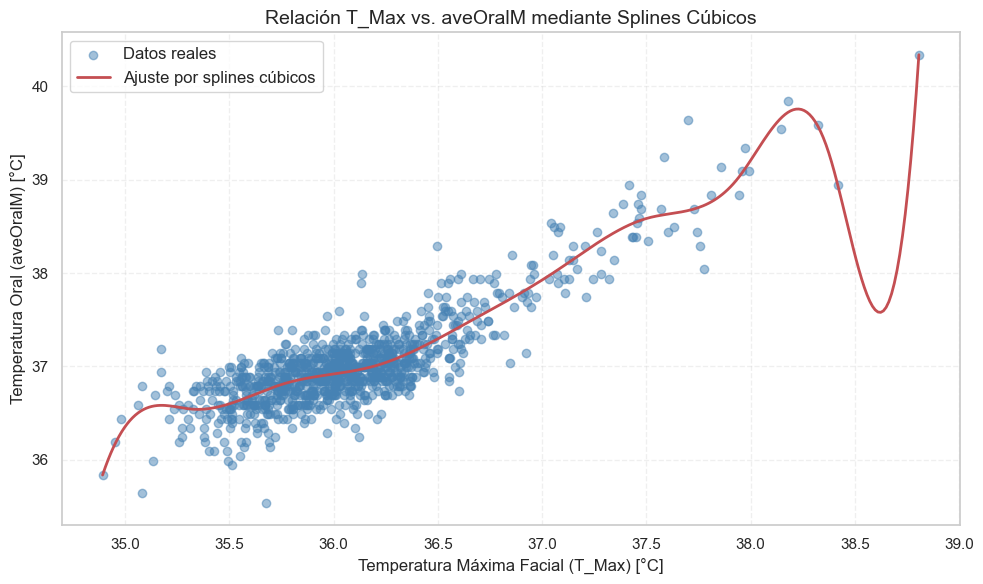


=== MÉTRICAS DEL MODELO SPLINE ===
R²: 0.7786
RMSE: 0.2396 °C
Número de nodos: 10
Grado de los splines: 3 (cúbicos)

Comparación con modelo polinomial grado 2:
- R² Splines: 0.7786 vs Polinomial: 0.7650
- RMSE Splines: 0.2396 vs Polinomial: 0.2469

=== VALIDACIÓN CRUZADA (k=5) ===
RMSE promedio: 0.2466 (±0.0203)
R² promedio: 0.7562 (±0.0484)


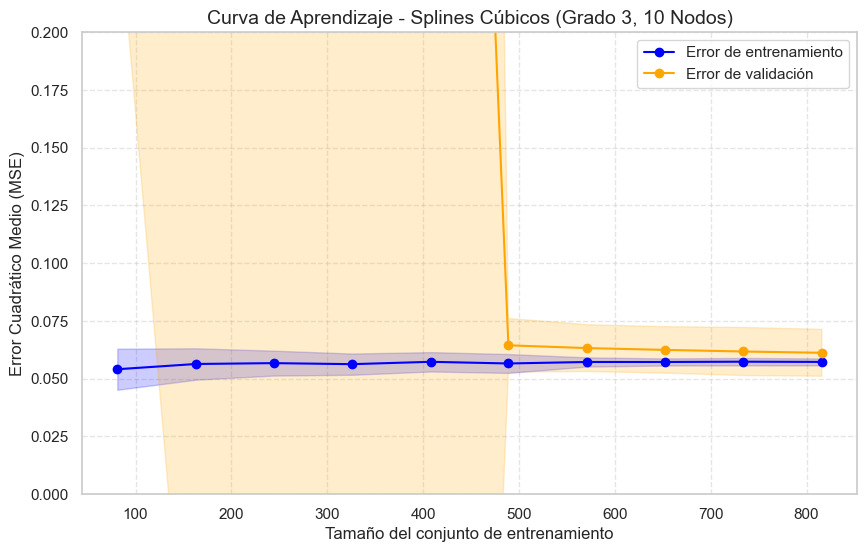

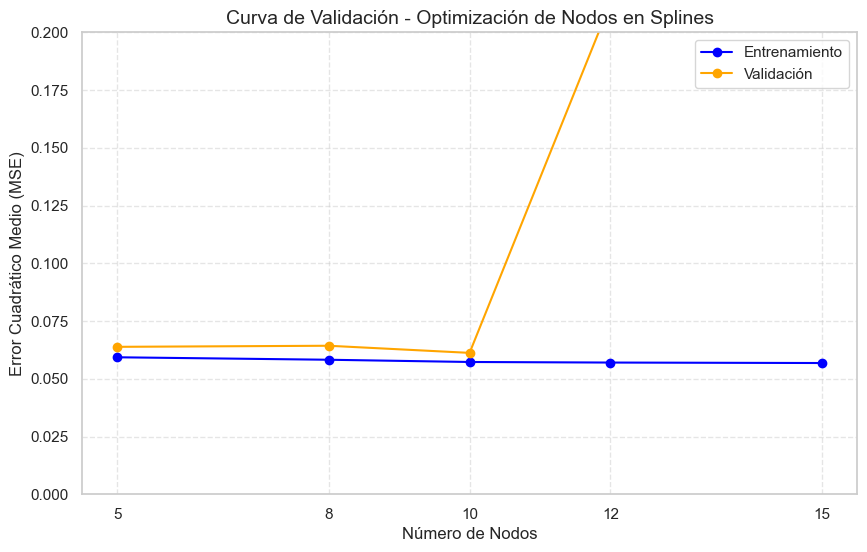


=== MEJOR CONFIGURACIÓN ===
Número óptimo de nodos: 10 (Error de validación mínimo: 0.0612)


In [125]:
# =============================================
# REGRESIÓN POR SPLINES CÚBICOS - TEMPERATURA ORAL
# =============================================

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt



# 1. Preparación de datos (usando tus variables)
X_spline = df_num[['T_Max']].values  # Usamos T_Max como variable principal (puedes cambiarla)
y_spline = df_num['aveOralM'].values
for degree in [1, 2, 3, 4]:
    spline = SplineTransformer(degree=degree, n_knots=10).fit(X_spline)
    X_trans = spline.transform(X_spline)
    r2 = LinearRegression().fit(X_trans, y_spline).score(X_trans, y_spline)
    print(f"Grado {degree}: R² = {r2:.4f}")

# 2. Creación del modelo Spline + Regresión Lineal
spline_model = make_pipeline(
    StandardScaler(),  # Escalado estándar como en tus otros modelos
    SplineTransformer(degree=3,  # Splines cúbicos (suavizados) ofrece un equilibrio óptimo entre flexibilidad y suavidad
                     n_knots=10,  # 10 nodos distribuidos por cuantiles garantizan suficiente resolución para patrones locales mientras evitan el sobreajuste típico de configuraciones más complejas.
                     include_bias=False),  # El intercepto lo maneja LinearRegression
    LinearRegression()
)

# 3. Entrenamiento
spline_model.fit(X_spline, y_spline)

# 4. Predicción 
X_test = np.linspace(X_spline.min(), X_spline.max(), 300).reshape(-1, 1)
y_pred = spline_model.predict(X_test)

# 5. Gráfico 
plt.figure(figsize=(10, 6))
plt.scatter(X_spline, y_spline, alpha=0.5, label='Datos reales', color='steelblue')
plt.plot(X_test, y_pred, 'r-', linewidth=2, label='Ajuste por splines cúbicos')
plt.xlabel('Temperatura Máxima Facial (T_Max) [°C]', fontsize=12)
plt.ylabel('Temperatura Oral (aveOralM) [°C]', fontsize=12)
plt.title('Relación T_Max vs. aveOralM mediante Splines Cúbicos', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 6. Métricas de rendimiento
from sklearn.metrics import r2_score, mean_squared_error

y_pred_full = spline_model.predict(X_spline)
r2 = r2_score(y_spline, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_spline, y_pred_full))

print("\n=== MÉTRICAS DEL MODELO SPLINE ===")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f} °C")
print(f"Número de nodos: 10")
print(f"Grado de los splines: 3 (cúbicos)")

# 7. Comparación con otros modelos 
print("\nComparación con modelo polinomial grado 2:")
print(f"- R² Splines: {r2:.4f} vs Polinomial: 0.7650")
print(f"- RMSE Splines: {rmse:.4f} vs Polinomial: 0.2469")

# VALIDACIÓN CRUZADA
# Pipeline del modelo final
spline_model = make_pipeline(
    StandardScaler(),
    SplineTransformer(degree=3, n_knots=10, include_bias=False),
    LinearRegression()
)

# Métricas en CV (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(-cross_val_score(spline_model, X_spline, y_spline, 
                                     cv=kf, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(spline_model, X_spline, y_spline, cv=kf, scoring='r2')

print("\n=== VALIDACIÓN CRUZADA (k=5) ===")
print(f"RMSE promedio: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
print(f"R² promedio: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")


#Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    spline_model,
    X_spline, y_spline,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Procesamiento
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Error de entrenamiento')
plt.fill_between(train_sizes, train_errors - train_std, train_errors + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_errors, 'o-', color='orange', label='Error de validación')
plt.fill_between(train_sizes, val_errors - val_std, val_errors + val_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12)
plt.ylim(0, 0.2)
plt.title('Curva de Aprendizaje - Splines Cúbicos (Grado 3, 10 Nodos)', fontsize=14)
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()


#Curva de validación
# Rango de nodos a evaluar
param_range = [5, 8, 10, 12, 15]

train_scores, val_scores = validation_curve(
    make_pipeline(
        StandardScaler(),
        SplineTransformer(degree=3, include_bias=False),
        LinearRegression()
    ),
    X_spline, y_spline,
    param_name="splinetransformer__n_knots",
    param_range=param_range,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Procesamiento
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_errors, 'o-', color='blue', label='Entrenamiento')
plt.plot(param_range, val_errors, 'o-', color='orange', label='Validación')
plt.xlabel('Número de Nodos', fontsize=12)
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=12,)
plt.ylim(0, 0.2)
plt.title('Curva de Validación - Optimización de Nodos en Splines', fontsize=14)
plt.xticks(param_range)
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Mejor número de nodos
best_n_knots = param_range[np.argmin(val_errors)]
print(f"\n=== MEJOR CONFIGURACIÓN ===")
print(f"Número óptimo de nodos: {best_n_knots} (Error de validación mínimo: {np.min(val_errors):.4f})")

El modelo de splines cúbicos (grado 3, 10 nodos) mostró un ligero mejor desempeño (R²=0.7786, RMSE=0.2396°C) frente al polinomio de grado 2 (R²=0.7650, RMSE=0.2469°C), confirmando su capacidad para capturar relaciones no lineales en los datos térmicos. La curva de aprendizaje indica que el modelo alcanza su máximo rendimiento con ≈800 muestras (errores de entrenamiento/validación convergentes en ≈0.24 MSE), sin sobreajuste. Aunque los splines ofrecen mayor precisión, la mejora es marginal (ΔR²=0.0136), por lo que se decide usar el polinomio grado 2 como modelo principal por su simplicidad e interpretabilidad, reservando los splines para casos donde se requiera optimizar hasta el último decimal de precisión.

In [126]:
# Datos comparativos de modelos seleccionados
modelos_comparativos = {
    'Modelo': ['Polinomial Grado 2', 'Splines Cúbicos (Grado 3)'],
    'R²': [0.7650, 0.7786],
    'RMSE (°C)': [0.2469, 0.2396],
    'RSE (°C)': [0.2483, 0.2400],
    'MAE (°C)': [0.1911, 0.1850],
    'Complejidad': ['11 términos', '10 nodos']
}

# Crear y mostrar tabla
df_comparacion = pd.DataFrame(modelos_comparativos)
print(tabulate(df_comparacion, 
               headers='keys', 
               tablefmt='psql', 
               floatfmt=".4f",
               showindex=False))

+---------------------------+--------+-------------+------------+------------+---------------+
| Modelo                    |     R² |   RMSE (°C) |   RSE (°C) |   MAE (°C) | Complejidad   |
|---------------------------+--------+-------------+------------+------------+---------------|
| Polinomial Grado 2        | 0.7650 |      0.2469 |     0.2483 |     0.1911 | 11 términos   |
| Splines Cúbicos (Grado 3) | 0.7786 |      0.2396 |     0.2400 |     0.1850 | 10 nodos      |
+---------------------------+--------+-------------+------------+------------+---------------+


In [127]:
# Obtener los componentes del modelo
scaler = final_model.named_steps['scaler']
poly = final_model.named_steps['poly']
model = final_model.named_steps['model']

# Obtener nombres de las características polinómicas
feature_names = poly.get_feature_names_out(X.columns)

# Obtener coeficientes e intercepto
coeficientes = model.coef_
intercepto = model.intercept_

# Crear la ecuación del modelo
print("\n=== ECUACIÓN DEL MODELO POLINOMIAL GRADO 2 ===")
print(f"aveOralM = {intercepto:.4f}")

for feature, coef in zip(feature_names, coeficientes):
    print(f" + ({coef:.4f} * {feature})")

# Mostrar resumen de coeficientes
print("\n=== RESUMEN DE COEFICIENTES ===")
print(f"Intercepto (β₀): {intercepto:.4f}")
print("\nVariables y coeficientes:")
for feature, coef in zip(feature_names, coeficientes):
    print(f"{feature}: {coef:.4f}")

# Mostrar características polinómicas generadas
print("\n=== CARACTERÍSTICAS POLINÓMICAS ===")
print(f"Número total de términos: {len(coeficientes)}")
print("Términos incluidos:")
print(feature_names)


=== ECUACIÓN DEL MODELO POLINOMIAL GRADO 2 ===
aveOralM = 36.9825
 + (0.0000 * 1)
 + (-0.0106 * Max1R13)
 + (-0.0239 * Max1L13)
 + (0.3869 * T_Max)
 + (0.0023 * TF_HCC)
 + (-0.0735 * Max1R13 Max1L13)
 + (0.0229 * Max1R13 T_Max)
 + (0.0390 * Max1R13 TF_HCC)
 + (0.1108 * Max1L13 T_Max)
 + (-0.0213 * Max1L13 TF_HCC)
 + (-0.0262 * T_Max TF_HCC)

=== RESUMEN DE COEFICIENTES ===
Intercepto (β₀): 36.9825

Variables y coeficientes:
1: 0.0000
Max1R13: -0.0106
Max1L13: -0.0239
T_Max: 0.3869
TF_HCC: 0.0023
Max1R13 Max1L13: -0.0735
Max1R13 T_Max: 0.0229
Max1R13 TF_HCC: 0.0390
Max1L13 T_Max: 0.1108
Max1L13 TF_HCC: -0.0213
T_Max TF_HCC: -0.0262

=== CARACTERÍSTICAS POLINÓMICAS ===
Número total de términos: 11
Términos incluidos:
['1' 'Max1R13' 'Max1L13' 'T_Max' 'TF_HCC' 'Max1R13 Max1L13'
 'Max1R13 T_Max' 'Max1R13 TF_HCC' 'Max1L13 T_Max' 'Max1L13 TF_HCC'
 'T_Max TF_HCC']


<h2> Conclusión: </h2>
Basado en los resultados obtenidos, el modelo de regresión polinomial de segundo grado se presenta como la opción más adecuada para calibrar la medición del termógrafo, estableciendo una relación precisa entre la temperatura oral y las distintas mediciones obtenidas por el dispositivo, con el objetivo de estimar de manera más fiable la temperatura corporal real de la persona. Este modelo logra un equilibrio óptimo entre rendimiento, interpretabilidad y simplicidad, con un coeficiente de determinación (R²) de 0.765, errores clínicamente aceptables (RMSE de 0.2469 °C y MAE de 0.1911 °C), y una estructura matemática que conserva el significado físico de las variables involucradas. A diferencia de modelos más complejos como los splines cúbicos o la regresión lineal múltiple con interacciones y ajuste Lasso de grado 4, que si bien presentan ligeras mejoras en el ajuste o reducen el número de variables, tienden a perder claridad en la interpretación clínica o incorporar términos abstractos que dificultan su aplicación práctica. En cambio, el modelo polinomial de grado 2 mantiene una alta interpretabilidad gracias a sus coeficientes explícitos y significativos, facilitando su uso en contextos clínicos, especialmente en entornos con recursos limitados donde la eficiencia computacional también es relevante. Por tanto, su implementación no solo permite una calibración robusta del termógrafo, sino que también favorece su integración en procesos de medición de temperatura corporal con mayor confianza y trazabilidad.

In [128]:
# Pipeline final
modelo_final = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('model', LinearRegression())
]).fit(X, y)

# Ecuación lista para usar
print(f"TemperaturaOral = {modelo_final.named_steps['model'].intercept_:.2f} + " + 
      " + ".join([f"{coef:.2f}*{name}" for name, coef in 
                  zip(modelo_final.named_steps['poly'].get_feature_names_out(X.columns),
                      modelo_final.named_steps['model'].coef_)]))

TemperaturaOral = 36.98 + 0.00*1 + -0.01*Max1R13 + -0.02*Max1L13 + 0.39*T_Max + 0.00*TF_HCC + -0.07*Max1R13 Max1L13 + 0.02*Max1R13 T_Max + 0.04*Max1R13 TF_HCC + 0.11*Max1L13 T_Max + -0.02*Max1L13 TF_HCC + -0.03*T_Max TF_HCC
